In [1]:
import sys
import traceback
import pandas as pd
import numpy as np
import time
from copy import deepcopy

from sklearn.base import BaseEstimator
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from scipy import sparse

import pickle

from IPython.display import display

import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns
pd.set_option('display.width', 15000)
pd.set_option('display.max_columns', 100)
sns.set_style("whitegrid", {'axes.grid' : False})
sns.set_context('poster')
%matplotlib inline

In [2]:
from surprise import Dataset, Reader
from surprise import NormalPredictor, BaselineOnly, SVD, SVDpp, NMF, \
SlopeOne, CoClustering, KNNBasic, KNNWithMeans, KNNBaseline

In [3]:
from recommender import plot_cm, print_results, IO
from recommender import ModeClassifier, BaselineMean, BaselineRegression, ALS1, ALS2, RS_surprise

In [4]:
%%time
# Load data

fig_dir = 'figs/modeling/Full/'

data_dir = 'data/Full/'
dfb = pd.read_pickle(data_dir + 'business.pkl')
dfr = pd.read_pickle(data_dir + 'review.pkl')
dfu = pd.read_pickle(data_dir + 'user.pkl')
datar = pd.read_pickle(data_dir + 'data_review.pkl')

Wall time: 8.88 s


In [5]:
print(dfb.shape)
print(dfu.shape)
print(datar.shape)

del dfb
del dfu
del dfr

datar.head()

(131025, 93)
(1117891, 22)
(4166778, 3)


,user_id,business_id,stars
0,0,0,2
1,1,0,2
2,2,0,2
3,3,0,3
4,4,0,2


In [6]:
# Split the dataset into a training set a test set

X_train, X_test, y_train, y_test = train_test_split(datar[['user_id', 'business_id']].values, datar['stars'].values, \
                                                   test_size=0.4, random_state=0)

In [7]:
models = [ModeClassifier(), RS_surprise(NormalPredictor()), BaselineMean(), BaselineRegression(), \
          RS_surprise(BaselineOnly()), RS_surprise(KNNBasic()), RS_surprise(KNNWithMeans()), RS_surprise(KNNBaseline()), \
          ALS1(), ALS2(), RS_surprise(SVD()), RS_surprise(SVDpp()), RS_surprise(NMF()), RS_surprise(SlopeOne()), \
          RS_surprise(CoClustering())]
model_names = ['Mode estimator', 'Normal predictor*', 'Baseline (mean)', 'Baseline (regression)', \
              'Baseline (ALS)*', 'KNN (basic)*', 'KNN (with means)*', 'KNN (baseline)*', \
              'SVD-ALS1', 'SVD-ALS2', 'SVD-SGD*', 'SVD++-SGD*', 'NMF-SGD*', 'Slope one*', 'Co-clustering*']
test = [True, True, True, True, \
       True, False, False, False, \
       True, True, True, True, True, False, False]
fignames = [fig_dir + str(i) + 'cm.png' for i in range(len(models))]
datanames = [data_dir + 'results/' + str(i) + '.pkl' for i in range(len(models))]
is_successful = deepcopy(test)

IO(data_dir + 'results/models.pkl').to_pickle(models)
IO(data_dir + 'results/model_names.pkl').to_pickle(model_names)
IO(data_dir + 'results/fignames.pkl').to_pickle(fignames)
IO(data_dir + 'results/datanames.pkl').to_pickle(datanames)

In [8]:
%%time

is_successful = []

for i, model in enumerate(models):
    try:
        print(model_names[i] + '...')
        if not test[i]:
            print('Estimator not tested')
            is_successful.append(False)
            print()
            continue
        model.fit(X_train, y_train)
        print(model_names[i] + ' successful.')
        try:
            IO(datanames[i]).to_pickle(model)
            print('Saving to pickle successful.')
        except:
            traceback.print_exc()
            print('Saving to pickle failed.')
        del model
        is_successful.append(True)
        print()
    except:
        traceback.print_exc()
        print(model_names[i] + ' failed.')
        is_successful.append(False)
        print()

IO(data_dir + 'results/is_successful.pkl').to_pickle(is_successful)

Mode estimator...
Mode estimator successful.
Saving to pickle successful.

Normal predictor*...
Normal predictor* successful.
Saving to pickle successful.

Baseline (mean)...
Baseline (mean) successful.
Saving to pickle successful.

Baseline (regression)...
Baseline (regression) successful.
Saving to pickle successful.

Baseline (ALS)*...
Estimating biases using als...
Baseline (ALS)* successful.
Saving to pickle successful.

KNN (basic)*...
Estimator not tested

KNN (with means)*...
Estimator not tested

KNN (baseline)*...
Estimator not tested

SVD-ALS1...
SVD-ALS1 successful.
Saving to pickle successful.

SVD-ALS2...
SVD-ALS2 successful.
Saving to pickle successful.

SVD-SGD*...
SVD-SGD* successful.
Saving to pickle successful.

SVD++-SGD*...
SVD++-SGD* successful.
Saving to pickle successful.

NMF-SGD*...
NMF-SGD* successful.
Saving to pickle successful.

Slope one*...
Estimator not tested

Co-clustering*...
Estimator not tested

Wall time: 2h 48min 19s


Mode estimator
Fitting time: 0.0 s.
RMSE on training set: 1.8974418969908236.
RMSE on test set: 1.8982016736340344.
r2 on training set: -0.7802585728808991.
r2 on test set: -0.7800870182754367.
Classification accuracy on training set: 0.42935186511076107.
Classification accuracy on test set: 0.4294647185596552.


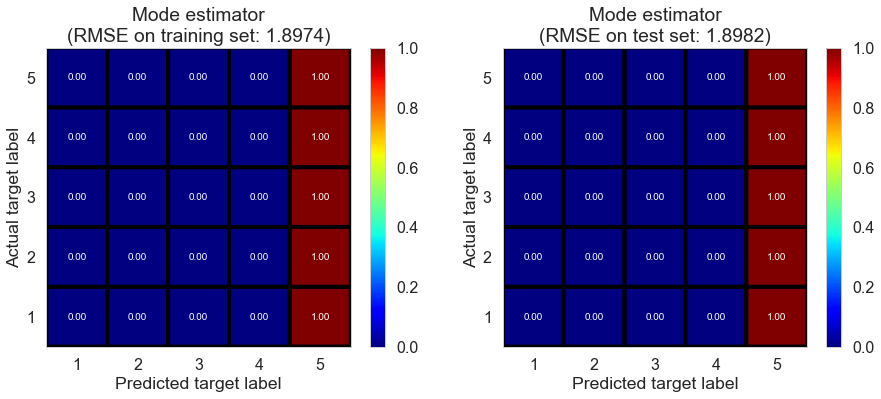


Normal predictor*
Fitting time: 17.363030672073364 s.
RMSE on training set: 1.8393635374990818.
RMSE on test set: 1.8398180861584597.
r2 on training set: -0.6716192902018356.
r2 on test set: -0.6712026398264395.
Classification accuracy on training set: 0.2389000930375438.
Classification accuracy on test set: 0.238509712535819.


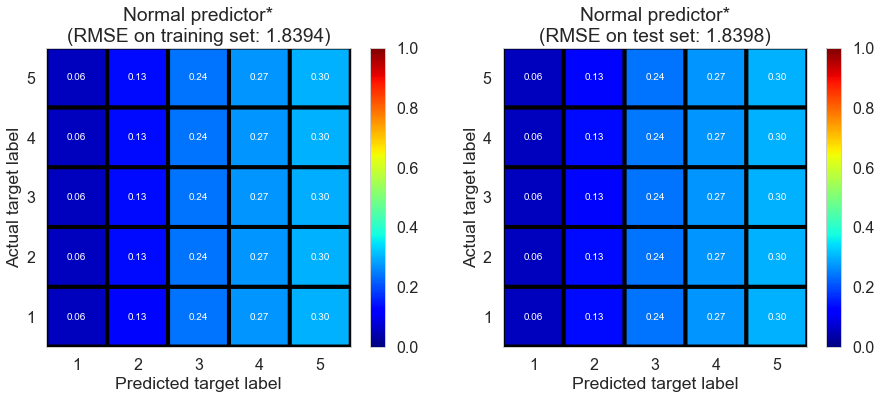


Baseline (mean)
Fitting time: 4.47938084602356 s.
RMSE on training set: 1.017752021100399.
RMSE on test set: 1.4061591131234328.
r2 on training set: 0.48781121954595774.
r2 on test set: 0.023155443642502993.
Classification accuracy on training set: 0.5345230885904612.
Classification accuracy on test set: 0.36663442754357084.


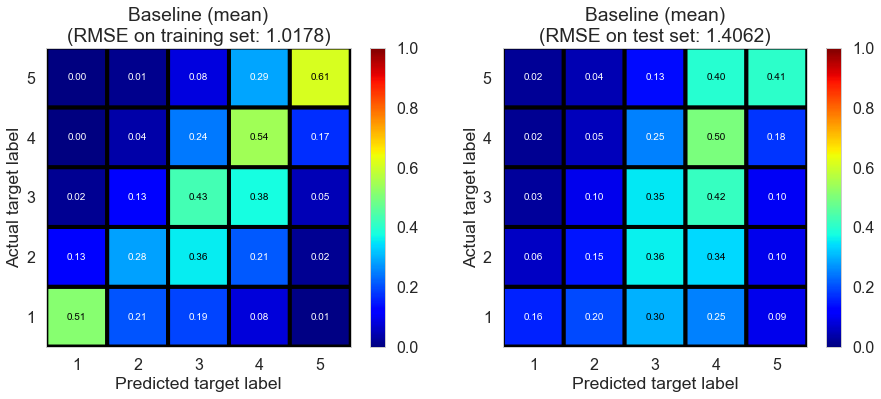


Baseline (regression)
Fitting time: 31.300803184509277 s.
RMSE on training set: 0.9380281120518971.
RMSE on test set: 1.2751169438701628.
r2 on training set: 0.564911281893269.
r2 on test set: 0.19673922021461898.
Classification accuracy on training set: 0.4375716481084899.
Classification accuracy on test set: 0.3303618141586549.


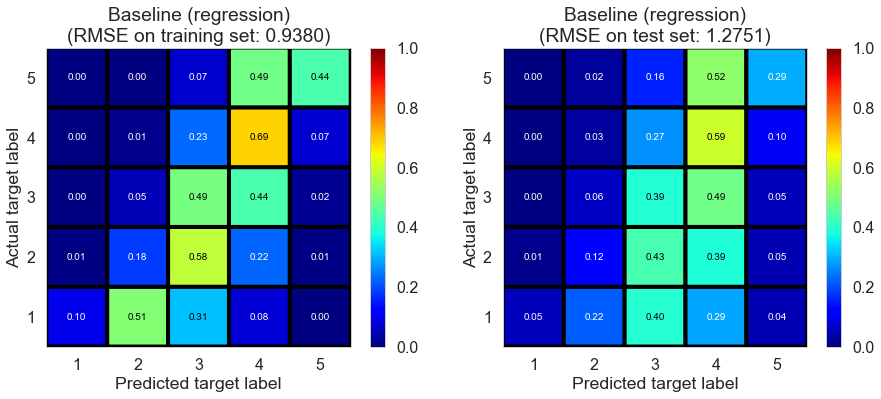


Baseline (ALS)*
Fitting time: 25.238244771957397 s.
RMSE on training set: 1.1753783297294202.
RMSE on test set: 1.265659667080828.
r2 on training set: 0.31687296530029974.
r2 on test set: 0.20861026960203677.
Classification accuracy on training set: 0.28911956724342475.
Classification accuracy on test set: 0.2709322306433265.


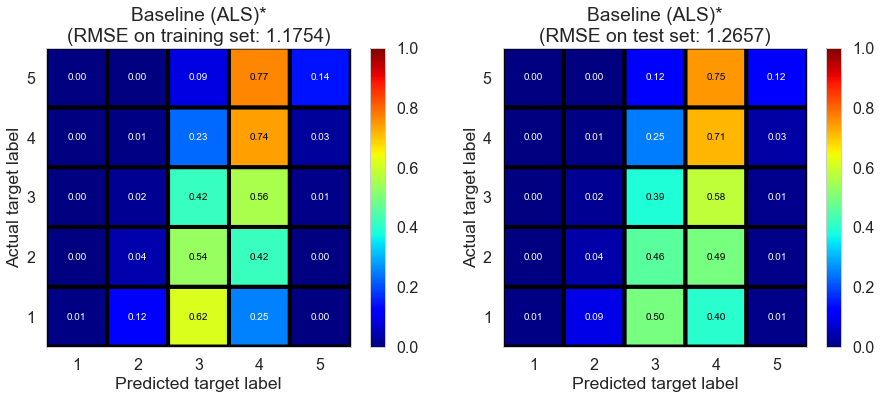


SVD-ALS1
Fitting time: 3932.1944539546967 s.
RMSE on training set: 0.5255204807948287.
RMSE on test set: 1.2683532145940133.
r2 on training set: 0.8634394031073069.
r2 on test set: 0.20523825079577385.
Classification accuracy on training set: 0.7514073628456209.
Classification accuracy on test set: 0.29503777497252076.


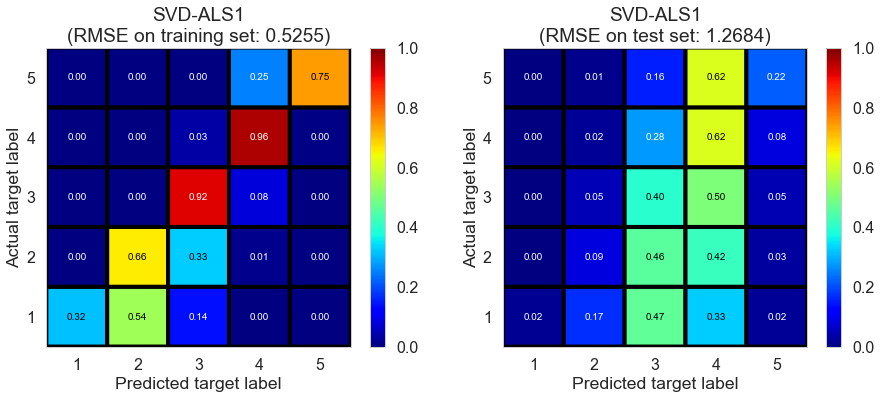


SVD-ALS2
Fitting time: 4134.556255340576 s.
RMSE on training set: 0.5267295906647157.
RMSE on test set: 1.2756920859717682.
r2 on training set: 0.862810286942641.
r2 on test set: 0.19601443448348432.
Classification accuracy on training set: 0.7444079476301826.
Classification accuracy on test set: 0.2790704092848674.


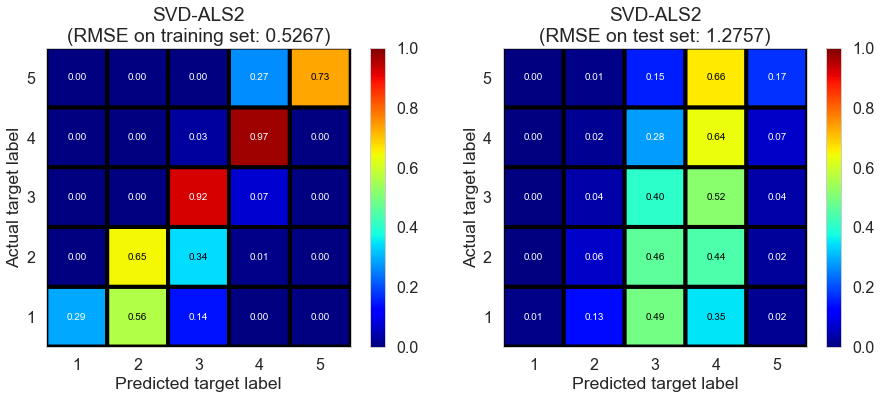


SVD-SGD*
Fitting time: 223.20220494270325 s.
RMSE on training set: 0.8311581669496636.
RMSE on test set: 1.2718304456474192.
r2 on training set: 0.6584034567829231.
r2 on test set: 0.20087454767142987.
Classification accuracy on training set: 0.4519820676734134.
Classification accuracy on test set: 0.2873825831937371.


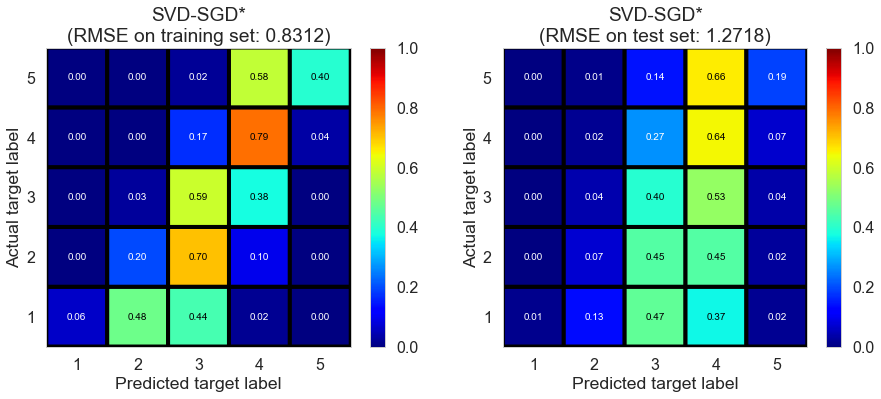


SVD++-SGD*
Fitting time: 1348.0361845493317 s.
RMSE on training set: 0.871291927550905.
RMSE on test set: 1.2783643583418085.
r2 on training set: 0.6246179560746175.
r2 on test set: 0.1926425884052927.
Classification accuracy on training set: 0.45573436861266864.
Classification accuracy on test set: 0.29121707889545406.


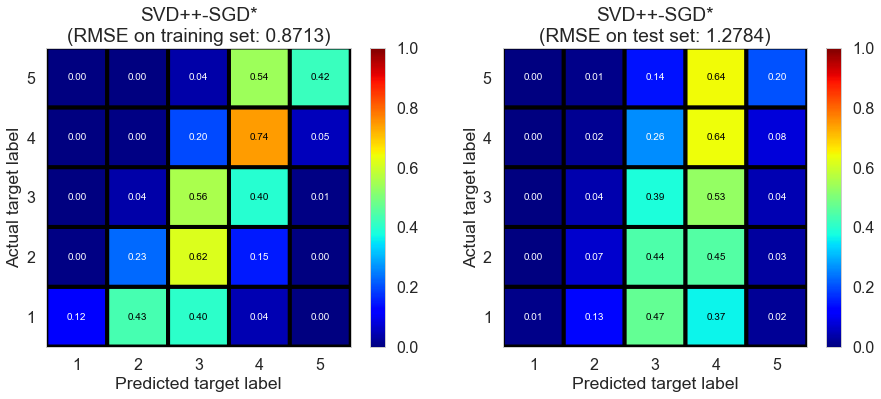


NMF-SGD*
Fitting time: 310.59255838394165 s.
RMSE on training set: 0.42773355356042725.
RMSE on test set: 1.4652149961774983.
r2 on training set: 0.9095324657233962.
r2 on test set: -0.0606185996767068.
Classification accuracy on training set: 0.8301428842278564.
Classification accuracy on test set: 0.2789312130710045.


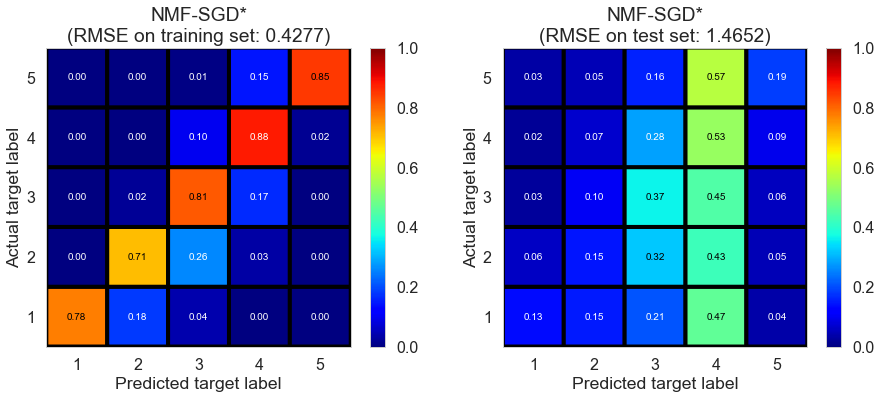


Wall time: 33min 8s


In [9]:
%%time

is_successful = IO(data_dir + 'results/is_successful.pkl').read_pickle()
datanames = IO(data_dir + 'results/datanames.pkl').read_pickle()
model_names = IO(data_dir + 'results/model_names.pkl').read_pickle()
fignames = IO(data_dir + 'results/fignames.pkl').read_pickle()

for i in range(len(is_successful)):
    if is_successful[i]:
        model = IO(datanames[i]).read_pickle()
        print_results(model, model_names[i], X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, \
                     figname=fignames[i])
        del model